# 소개

- CRM(고객 관계 관리) 분석

## CRM 분석이란 무엇인가요?
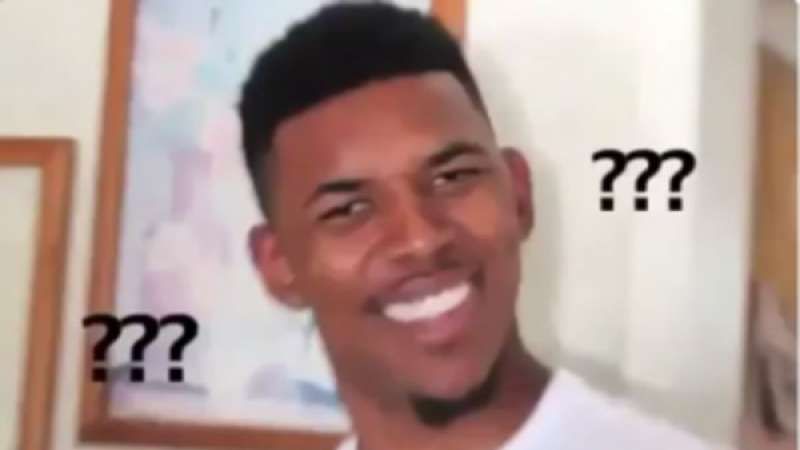

분석적 CRM은 기업이 고객 만족도와 고객 유지율을 높이기 위해 고객 상호 작용에 대한 데이터를 수집하는 CRM의 하위 집합입니다. 분석 CRM은 보이지 않는 프로세스이므로 고객은 자신의 행동과 회사와의 상호 작용에 대한 분석이 이루어지고 있다는 사실을 알지 못합니다.
기업은 고객 행동, 경험 및 이러한 경험의 최종 효과에 대해 수집된 정보를 기반으로 소비자 행동을 예측하고 더 나은 반응을 보일 가능성이 높은 상품을 추천할 수 있습니다.
분석적 CRM은 고객 관계 관리의 필수적인 부분입니다. 분석 CRM은 다음과 같은 다양한 종류의 소비자 데이터를 축적하고 분석합니다:

- **판매 데이터**: 구매 및 반품 내역, 브랜드 선호도 등
- **금융 데이터**: 결제 유형, 신용 점수 등을 포함한 결제 및 신용 기록
- **마케팅 데이터**: 마케팅 캠페인에 대한 고객 반응률, 고객 만족도 데이터, 리텐션 데이터 등

## 프로젝트 프로세스 정보
이번 프로젝트에서는 CRM 분석에 대한 프로젝트를 구현해 보려고 합니다. 프로젝트의 단계는 먼저, CRM과 CLTV 모델을 적용하기 위해 데이터셋을 변경할 것입니다. 데이터셋을 준비한 후 RFM 작업을 한 후 CLTV 작업을 할 예정입니다.

# Content <a id = "cont"></a>
- [EDA](#1)
- [데이터 세트 준비하기](#2)
    - [Null값과 음수 조정하기](#2a)
    - [Total Price](#2b)
- [RFM](#3)
    - [Dataset](#3a)
    - [세분화](#3b)
    - [Review The RFM DataFrame](#3c)
- [CLTV](#4)
    - [데이터에서 이상값 처리 ](#4a)
    - [CLTV DataFrame 준비하기](#4b)
    - [BG-NBD](#4c)
    - [Gamma Gamma](#4d)
    - [Segmentasyon](#4e)
    - [Review The CLTV DataFrame](#4f)
- [Conclusion](#5)

In [182]:
!pip install lifetimes

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler
import warnings 

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: '%.3f' % x)

In [184]:
data_ = pd.read_csv("/kaggle/input/online-retail-ii-uci/online_retail_II.csv")
data = data_.copy()

# EDA <a id = "1"> </a>

In [185]:
# first view to the dateset
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.950,13085.000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750,13085.000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750,13085.000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.100,13085.000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.250,13085.000,United Kingdom


In [186]:
# I prepared a function for reviewing the dataset.
def Df_info(df):
    print("########### Head ###########")
    print(df.head())
    print("########### Tail ###########")
    print(df.tail())
    print("########### Shape ###########")
    print(df.shape)
    print("########### Info ###########")
    print(df.info())
    print("########### Info ###########")
    print(df.columns)
    print("########### Quantiles ###########")
    print(df.describe().T)
    print("########### NA ###########")
    print(df.isnull().sum())

In [187]:
Df_info(data)

########### Head ###########
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00  6.950    13085.000  United Kingdom  
1  2009-12-01 07:45:00  6.750    13085.000  United Kingdom  
2  2009-12-01 07:45:00  6.750    13085.000  United Kingdom  
3  2009-12-01 07:45:00  2.100    13085.000  United Kingdom  
4  2009-12-01 07:45:00  1.250    13085.000  United Kingdom  
########### Tail ###########
        Invoice StockCode                      Description  Quantity  \
1067366  581587     22899     CHILDREN'S APRON DOLLY GIRL          6   
1067367  58

전체 데이터 집합을 살펴보면 데이터 집합에서 사용할 수 있는 'Invoice', 'Quantity', 'InvoiceDate', 'Price' 및 'Customer ID' 열이 있습니다. 이 열을 사용하여 이 데이터 집합에 RFM 및 CLTV 공식을 모두 적용하겠습니다.

In [188]:
# number of Custimer in the dataset.
print("The number of customer in the dataset:", data["Customer ID"].nunique())

The number of customer in the dataset: 5942


In [189]:
# number of Invoice in the dataset.
print("The number of customer in the dataset:", data["Invoice"].nunique())

The number of customer in the dataset: 53628


In [190]:
# Total number of products sold in the dataset
print("The sum of product in the dataset:", data["Quantity"].sum())

The sum of product in the dataset: 10608492


In [191]:
# Total revenue in the dataset
total_price_of_df = ((data["Quantity"] * data["Price"]).sum()).astype(int)
print("The sum of price in the dataset:", total_price_of_df)

The sum of price in the dataset: 19287250


In [192]:
# Total number of product in the dataset.
print("the sum of product in the dataset:", data["Description"].count())

the sum of product in the dataset: 1062989


In [193]:
# Dataset ordered from highest price to lowest price
data.sort_values(by = "Price", ascending  = False).head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
748142,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.000,15098.000,United Kingdom
241827,512771,M,Manual,1,2010-06-17 16:53:00,25111.090,NaN,United Kingdom
241824,C512770,M,Manual,-1,2010-06-17 16:52:00,25111.090,17399.000,United Kingdom
320581,C520667,BANK CHARGES,Bank Charges,-1,2010-08-27 13:42:00,18910.690,NaN,United Kingdom
1050063,C580605,AMAZONFEE,AMAZON FEE,-1,2011-12-05 11:36:00,17836.460,NaN,United Kingdom


- null값과 결측치가 보인다. 깨끗하게 해줄 필요가 있다.
- 귀찮게 다시 쓰지 않기 위해서 위의 식을 함수로 만들겠다.

In [194]:
# The function
def Df_info2(df):
   
    print("The number of customer in the dataset:", df["Customer ID"].nunique())
    print("-------------------------------------------------------")
   
    print("The number of invoice in the dataset:", df["Invoice"].nunique())
    print("-------------------------------------------------------")
   
    print("The sum of product in the dataset:", df["Quantity"].sum())
    print("-------------------------------------------------------")

    total_price_of_df = ((df["Quantity"] * df["Price"]).sum()).astype(int)
    print("The sum of price in the dataset:", total_price_of_df)
    print("-------------------------------------------------------")
   
    print("the sum of product in the dataset:", df["Description"].count())
    print("-------------------------------------------------------")
    print("Our dataset, sort by highest salary")
    print(df.sort_values(by = "Price", ascending  = False).head())
    print("-------------------------------------------------------")
    print("Our dataset, sorted by lowest salary")
    print(df.sort_values(by = "Price", ascending  = True).head())

# 데이터 세트 준비하기 <a id = "2"></a>
이 장에서는 RFM과 cltv에 대한 데이터셋을 준비하겠습니다. 데이터 집합을 검토하는 동안 몇 가지 잘못 입력된 값을 발견했습니다. 이 값을 지우고 "InvoiceDate" 열을 DateTime 유형으로 변경하겠습니다.

In [195]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.950,13085.000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750,13085.000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750,13085.000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.100,13085.000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.250,13085.000,United Kingdom


In [196]:
# Changing the type of the 'InvoiceDate' column
data["InvoiceDate"] = data["InvoiceDate"].apply(pd.to_datetime)

In [197]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


## Null값과 음수 조정하기 <a id = "2a"></a>

In [198]:
# Dropping the null values in the dataset.
data.dropna(inplace = True)

In [199]:
# The state of the dataset after clearing the null values.
Df_info(data)

########### Head ###########
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00  6.950    13085.000  United Kingdom  
1 2009-12-01 07:45:00  6.750    13085.000  United Kingdom  
2 2009-12-01 07:45:00  6.750    13085.000  United Kingdom  
3 2009-12-01 07:45:00  2.100    13085.000  United Kingdom  
4 2009-12-01 07:45:00  1.250    13085.000  United Kingdom  
########### Tail ###########
        Invoice StockCode                      Description  Quantity  \
1067366  581587     22899     CHILDREN'S APRON DOLLY GIRL          6   
1067367  581587  

모양에 대한 챕터를 보면 일부 값이 삭제된 것으로 표시되고 NA에 대한 챕터를 확인하면 null 값이 없는 것으로 표시됩니다. 하지만 여전히 문제가 있습니다. 사 분위수 챕터에 음수 값이 있습니다. 이를 제거해야 합니다. 

수량 섹션에 여전히 음수 값이 있는 이유는 이러한 송장이 반품 송장이기 때문에 처음에 C로 시작하는 송장입니다. 값을 표시합니다:

In [200]:
# Values starting with 'C'
data[data["Invoice"].str.contains("C", na = False)].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.950,16321.000,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.650,16321.000,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.250,16321.000,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.100,16321.000,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.950,16321.000,Australia


In [201]:
# In this code, I am getting values not starting with 'C'.
data = data[~data["Invoice"].str.contains("C", na = False)]

In [202]:
Df_info(data)

########### Head ###########
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00  6.950    13085.000  United Kingdom  
1 2009-12-01 07:45:00  6.750    13085.000  United Kingdom  
2 2009-12-01 07:45:00  6.750    13085.000  United Kingdom  
3 2009-12-01 07:45:00  2.100    13085.000  United Kingdom  
4 2009-12-01 07:45:00  1.250    13085.000  United Kingdom  
########### Tail ###########
        Invoice StockCode                      Description  Quantity  \
1067366  581587     22899     CHILDREN'S APRON DOLLY GIRL          6   
1067367  581587  

we are looking and we dont have any negative values anymore

In [203]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.950,13085.000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750,13085.000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750,13085.000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.100,13085.000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.250,13085.000,United Kingdom


In [204]:
data = data[data["Quantity"] > 0]
data = data[data["Price"] > 0]

## Total Price <a id = "2b"></a>

In [205]:
# Calculating total price and adding it.
data["Total_Price"] = data["Quantity"] * data["Price"]

In [206]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total_Price
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.950,13085.000,United Kingdom,83.400
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750,13085.000,United Kingdom,81.000
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750,13085.000,United Kingdom,81.000
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.100,13085.000,United Kingdom,100.800
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.250,13085.000,United Kingdom,30.000


- 이제 데이터 세트에 각 송장의 총 비용이 얼마인지 보여주는 결과가 생겼습니다.

- 이제 데이터 분석 부분으로 돌아가서, 이 부분에서는 앞서 했던 몇 가지 작업을 해보겠습니다!

In [207]:
Df_info(data)

########### Head ###########
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  Total_Price  
0 2009-12-01 07:45:00  6.950    13085.000  United Kingdom       83.400  
1 2009-12-01 07:45:00  6.750    13085.000  United Kingdom       81.000  
2 2009-12-01 07:45:00  6.750    13085.000  United Kingdom       81.000  
3 2009-12-01 07:45:00  2.100    13085.000  United Kingdom      100.800  
4 2009-12-01 07:45:00  1.250    13085.000  United Kingdom       30.000  
########### Tail ###########
        Invoice StockCode                      Description  Quantity  \
1067366  58

In [208]:
Df_info2(data)

The number of customer in the dataset: 5878
-------------------------------------------------------
The number of invoice in the dataset: 36969
-------------------------------------------------------
The sum of product in the dataset: 10706167
-------------------------------------------------------
The sum of price in the dataset: 17743429
-------------------------------------------------------
the sum of product in the dataset: 805549
-------------------------------------------------------
Our dataset, sort by highest salary
       Invoice StockCode Description  Quantity         InvoiceDate     Price  \
135013  502263         M      Manual         1 2010-03-23 15:22:00 10953.500   
358639  524159         M      Manual         1 2010-09-27 16:12:00 10468.800   
74356   496115         M      Manual         1 2010-01-29 11:04:00  8985.600   
698843  551697      POST     POSTAGE         1 2011-05-03 13:46:00  8142.750   
129987  501768         M      Manual         1 2010-03-19 11:45:00  

## RFM <a id = "3a"></a>

**RFM(최근성, 빈도, 금전적 가치)**은 구매 패턴이나 습관에 따라 기업의 소비자층을 세분화하는 마케팅 분석에 사용되는 모델입니다. 특히 고객의 최근성(얼마나 오래 전에 구매했는지), 빈도(얼마나 자주 구매하는지), 금전적 가치(얼마나 많은 돈을 지출하는지)를 평가합니다.
그런 다음 RFM은 소비 습관을 측정하고 분석하여 낮은 점수를 받은 고객을 개선하고 높은 점수를 받은 고객을 유지함으로써 회사 또는 조직의 우수 고객을 식별하는 데 사용됩니다.
최근성, 빈도, 금전적 가치에 대한 이해
RFM 모델은 세 가지 정량적 요소를 기반으로 합니다:

**최근성**: 고객이 얼마나 최근에 구매했는지

**빈도**: 고객이 구매를 하는 빈도

**금전적 가치**: 고객이 구매에 지출하는 금액

RFM 분석은 일반적으로 1~5점 척도(숫자가 높을수록 더 좋은 결과)로 이 세 가지 범주 각각에서 고객의 순위를 수치화합니다. '최고' 고객은 모든 카테고리에서 최고 점수를 받게 됩니다.

이 세 가지 RFM 요소는 고객이 기업과 다시 거래할 가능성(또는 가능성 없음)을 합리적으로 예측하거나 자선 단체의 경우 다른 기부를 할 가능성을 예측하는 데 사용할 수 있습니다.

## DataSet  <a id = "3a"></a>


In [209]:
# 데이터 집합의 마지막 날짜입니다. 최근 값을 계산하려면 이 값이 필요합니다. 
# 이 값을 사용하여 today_date 값을 지정하겠습니다.
data["InvoiceDate"].max()


Timestamp('2011-12-09 12:50:00')

In [210]:
today_date = dt.datetime(2011,12, 11)

In [211]:
# I create rfm dataframe.
df_rfm = data.groupby("Customer ID").agg({"InvoiceDate" : lambda InvoiceDate: (today_date - InvoiceDate.max()).days, # Recency
                                "Invoice" : lambda Invoice : Invoice.nunique(), # Frequency
                                "Total_Price" : lambda Total_Prize: Total_Prize.sum()}) # Monetary

In [212]:
df_rfm.head()

,InvoiceDate,Invoice,Total_Price
Customer ID,,,
12346.000,326,12,77556.460
12347.000,3,8,5633.320
12348.000,76,5,2019.400
12349.000,19,4,4428.690
12350.000,311,1,334.400


In [213]:
df_rfm.columns = ["Recency", "Frequency", "Monetary"]
df_rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.000,326,12,77556.460
12347.000,3,8,5633.320
12348.000,76,5,2019.400
12349.000,19,4,4428.690
12350.000,311,1,334.400


In [214]:
Df_info(df_rfm)

########### Head ###########
             Recency  Frequency  Monetary
Customer ID                              
12346.000        326         12 77556.460
12347.000          3          8  5633.320
12348.000         76          5  2019.400
12349.000         19          4  4428.690
12350.000        311          1   334.400
########### Tail ###########
             Recency  Frequency  Monetary
Customer ID                              
18283.000          4         22  2736.650
18284.000        432          1   461.680
18285.000        661          1   427.000
18286.000        477          2  1296.430
18287.000         43          7  4182.990
########### Shape ###########
(5878, 3)
########### Info ###########
<class 'pandas.core.frame.DataFrame'>
Float64Index: 5878 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    5878 non-null   int64  
 1   Frequency  5878 non-null   int64  
 2   Mon

In [215]:
# The first values with the highest monetary value
df_rfm.sort_values(by = "Monetary", ascending = False).head()

,Recency,Frequency,Monetary
Customer ID,,,
18102.000,1,145,608821.650
14646.000,2,151,528602.520
14156.000,10,156,313946.370
14911.000,2,398,295972.630
17450.000,9,51,246973.090


In [216]:
# The first five values with the lowest monetary value
df_rfm.sort_values(by = "Monetary", ascending = True).head()

,Recency,Frequency,Monetary
Customer ID,,,
14095.000,723,1,2.950
16738.000,298,1,3.750
13788.000,506,1,3.750
14792.000,64,1,6.200
15913.000,535,1,6.300


## 세분화 <a id="3b"></a>
- 이 장에서는 recency, Frequency, Monetary값을
- 최근도_점수, 빈도_점수 및 금전적_점수로 분할하겠습니다.


**Recency_Score, Frequency_Score, Monetary_Score**<br>
최근성, 빈도 및 금전적 점수를 5점에서 1점 사이로 평가합니다. 이 섹션에서는 5점인 데이터가 최근성 점수가 가장 높은 데이터이고, 1점인 데이터가 가장 낮은 데이터입니다.

**Recency_Score:**
최근값이 높으면 좋지 않습니다. 최근값이 높다는 것은 고객이 회사를 떠난 날을 의미하기 때문입니다. 최근값이 낮은 고객은 회사를 멀리하지 않는 고객입니다.

**Frequency_Score:**
빈도 값이 높을수록 좋은 고객입니다. 빈도 값은 얼마나 많은 고객이 우리 회사를 더 많이 이용하는지를 나타냅니다.

**Monetary_Score:**
금전적 가치가 높을수록 좋습니다. 금전적 가치는 고객이 회사에 지불하는 금액입니다.

In [217]:
# Create the recency_score, frequency_score, and monetary_score values.
df_rfm["Recency_Score"] = pd.qcut(df_rfm["Recency"], 5, labels=[1, 2, 3, 4, 5])
df_rfm["Frequency_Score"] = pd.qcut(df_rfm["Frequency"], 5, labels=[1, 2, 3, 4], duplicates='drop')
df_rfm["Monetary_Score"] = pd.qcut(df_rfm["Monetary"], 5, labels=[1, 2, 3, 4, 5])


In [218]:
# Last version of df_rfm dataframe
df_rfm.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score
Customer ID,,,,,,
12346.000,326,12,77556.460,4,4,5
12347.000,3,8,5633.320,1,3,5
12348.000,76,5,2019.400,3,3,4
12349.000,19,4,4428.690,1,2,5
12350.000,311,1,334.400,4,1,2


In [219]:
# I create the RF_score using the recency_score and frequency_score.
df_rfm["RF_Score"] = df_rfm["Recency_Score"].astype(str) + df_rfm["Frequency_Score"].astype(str)

In [220]:
# Last version of df_rfm dateframe.
df_rfm.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score
Customer ID,,,,,,,
12346.000,326,12,77556.460,4,4,5,44
12347.000,3,8,5633.320,1,3,5,13
12348.000,76,5,2019.400,3,3,4,33
12349.000,19,4,4428.690,1,2,5,12
12350.000,311,1,334.400,4,1,2,41


In [221]:
# Seg_map is customer group.
seg_map = {
    r'[1-2][1-2]' : 'hibernatig',
    r'[1-2][3-4]' : 'at_Risk',
    r'[1-2]5' : 'cant-loose',
    r'3[1-2]' : 'about_to_sleep',
    r'33' : 'need_attention',
    r'[3-4][4-5]' : 'loyal_customers',
    r'41' : 'promising',
    r'51' : 'new_customers',
    r'[4-5][2-3]' : 'potential_loyalists',
    r'5[4-5]' : 'champions'}

In [222]:
# I create segment using RF_score and segmap.
df_rfm["segment"] = df_rfm["RF_Score"].replace(seg_map, regex = True)

In [223]:
# Last version of df_rfm dataframe.
df_rfm.head()



,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score,segment
Customer ID,,,,,,,,
12346.000,326,12,77556.460,4,4,5,44,loyal_customers
12347.000,3,8,5633.320,1,3,5,13,at_Risk
12348.000,76,5,2019.400,3,3,4,33,need_attention
12349.000,19,4,4428.690,1,2,5,12,hibernatig
12350.000,311,1,334.400,4,1,2,41,promising


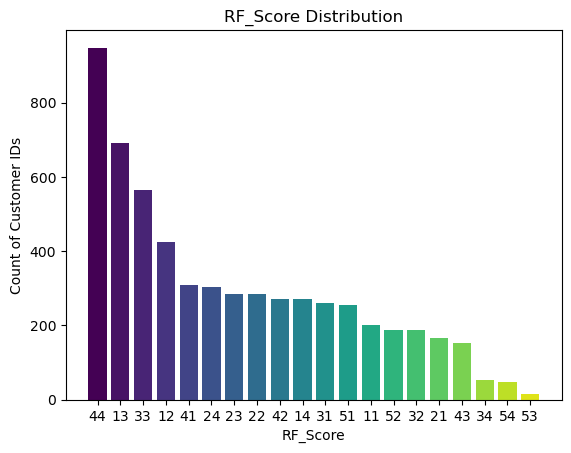

In [224]:
import numpy as np
import matplotlib.pyplot as plt

# Define the colormap
cmap = plt.get_cmap('viridis')

# Get unique RF scores and their counts
unique_scores = df_rfm['RF_Score'].unique()
scores_count = df_rfm['RF_Score'].value_counts()

# Assign colors based on the colormap
colors = [cmap(i / len(unique_scores)) for i in range(len(unique_scores))]

# Create the bar plot
plt.bar(unique_scores, scores_count, color=colors)
plt.title('RF_Score Distribution')
plt.xlabel('RF_Score')
plt.ylabel('Count of Customer IDs')
plt.show()


## RFM 데이터프레임 리뷰 <a id= "3c"></a>
- 통계값을 알아보겠습니다.

In [ ]:
df_rfm[["segment", "Recency", "Frequency", "Monetary"]].groupby("segment").agg(["mean", "sum","count"])

In [ ]:
def check_RF_Score(rfScore):
    print(f"############ Top five Recency - {rfScore} ############")
    print(df_rfm[df_rfm["RF_Score"] == rfScore].sort_values(by = "Recency", ascending = True).head())
    print(f"############ Bottom five Recency - {rfScore} ############")
    print(df_rfm[df_rfm["RF_Score"] == rfScore].sort_values(by = "Recency", ascending = False).head())
    
    print(f"############ Top five Frequency - {rfScore} ############")
    print(df_rfm[df_rfm["RF_Score"] == rfScore].sort_values(by = "Frequency", ascending = False).head())
    print(f"############ Bottom five Frequency - {rfScore} ############")
    print(df_rfm[df_rfm["RF_Score"] == rfScore].sort_values(by = "Frequency", ascending = True).head())
    
    print(f"############ Top five Monetary - {rfScore} ############")
    print(df_rfm[df_rfm["RF_Score"] == rfScore].sort_values(by = "Monetary", ascending = False).head())
    print(f"############ Bottom five Monetary - {rfScore} ############")
    print(df_rfm[df_rfm["RF_Score"] == rfScore].sort_values(by = "Monetary", ascending = True).head())

In [232]:
check_RF_Score("54")

############ Top five Recency - 54 ############
             Recency  Frequency  Monetary Recency_Score Frequency_Score  \
Customer ID                                                               
14648.000        417         15  4546.860             5               4   
14590.000        425         20  3006.620             5               4   
12835.000        428         41  6043.310             5               4   
12986.000        429         10  2729.840             5               4   
13446.000        431         11  3881.890             5               4   

            Monetary_Score RF_Score    segment  
Customer ID                                     
14648.000                5       54  champions  
14590.000                5       54  champions  
12835.000                5       54  champions  
12986.000                4       54  champions  
13446.000                5       54  champions  
############ Bottom five Recency - 54 ############
             Recency  Frequency 

It sends us the best and worst column data from the df_rfm dataframe according to the column variable we will enter in the code block below.

In [233]:
def check_rfm_best_and_worst(column):
    if (column == "Recency"):
        print(f"############ Top five - {column} ############")
        print(df_rfm.sort_values(by = column, ascending = True).head())
        print(f"############ Bottom five - {column} ############")
        print(df_rfm.sort_values(by = column, ascending = False).head())
    else:
        print(f"############ Top five - {column} ############")
        print(df_rfm.sort_values(by = column, ascending = False).head())
        print(f"############ Bottom five - {column} ############")
        print(df_rfm.sort_values(by = column, ascending = True).head())

In [234]:
check_rfm_best_and_worst("Recency")

############ Top five - Recency ############
             Recency  Frequency  Monetary Recency_Score Frequency_Score  \
Customer ID                                                               
12433.000          1         10 20581.260             1               4   
14051.000          1         37 22434.000             1               4   
17581.000          1         43 18757.750             1               4   
13069.000          1         38  9683.130             1               4   
16558.000          1         38 13873.510             1               4   

            Monetary_Score RF_Score  segment  
Customer ID                                   
12433.000                5       14  at_Risk  
14051.000                5       14  at_Risk  
17581.000                5       14  at_Risk  
13069.000                5       14  at_Risk  
16558.000                5       14  at_Risk  
############ Bottom five - Recency ############
             Recency  Frequency  Monetary Recency_Sc

In [237]:
check_rfm_best_and_worst("Frequency")

############ Top five - Frequency ############
             Recency  Frequency   Monetary Recency_Score Frequency_Score  \
Customer ID                                                                
14911.000          2        398 295972.630             1               4   
12748.000          1        336  56599.390             1               4   
17841.000          2        211  70884.070             1               4   
15311.000          1        208 116771.160             1               4   
13089.000          3        203 116737.860             1               4   

            Monetary_Score RF_Score  segment  
Customer ID                                   
14911.000                5       14  at_Risk  
12748.000                5       14  at_Risk  
17841.000                5       14  at_Risk  
15311.000                5       14  at_Risk  
13089.000                5       14  at_Risk  
############ Bottom five - Frequency ############
             Recency  Frequency  Monetary

In [238]:
check_rfm_best_and_worst("Monetary")

############ Top five - Monetary ############
             Recency  Frequency   Monetary Recency_Score Frequency_Score  \
Customer ID                                                                
18102.000          1        145 608821.650             1               4   
14646.000          2        151 528602.520             1               4   
14156.000         10        156 313946.370             1               4   
14911.000          2        398 295972.630             1               4   
17450.000          9         51 246973.090             1               4   

            Monetary_Score RF_Score  segment  
Customer ID                                   
18102.000                5       14  at_Risk  
14646.000                5       14  at_Risk  
14156.000                5       14  at_Risk  
14911.000                5       14  at_Risk  
17450.000                5       14  at_Risk  
############ Bottom five - Monetary ############
             Recency  Frequency  Monetary R

The code block below gives us the best and worst values from the df_rfm dataframe according to the segment value we will enter. At the same time, gives the mean, total and count of the segment values at recency, frequency and monetary values.

In [239]:
def check_rfm_seg(segment):
    print(f"############ Top five - {segment} ############")
    print(df_rfm[df_rfm["segment"] == segment].sort_values(by = "segment", ascending = False).head())
    print(f"############ Bottom five - {segment} ############")
    print(df_rfm[df_rfm["segment"] == segment].sort_values(by = "segment", ascending = True).head())
    print(f"############ Quantiles with {segment} ############")
    print(df_rfm[df_rfm["segment"] == segment][["segment", "Recency", "Frequency", "Monetary"]].groupby("segment").agg(["count", "mean", "sum"]))

In [240]:
check_rfm_seg("hibernatig")

############ Top five - hibernatig ############
             Recency  Frequency  Monetary Recency_Score Frequency_Score  \
Customer ID                                                               
12349.000         19          4  4428.690             1               2   
16376.000          9          2   987.010             1               1   
16322.000          2          2   326.750             1               1   
16337.000         37          1   151.050             2               1   
16343.000         17          3   687.070             1               2   

            Monetary_Score RF_Score     segment  
Customer ID                                      
12349.000                5       12  hibernatig  
16376.000                3       11  hibernatig  
16322.000                2       11  hibernatig  
16337.000                1       21  hibernatig  
16343.000                3       12  hibernatig  
############ Bottom five - hibernatig ############
             Recency  Fre

In [265]:
check_rfm_seg("champions")

############ Top five - champions ############
             Recency  Frequency  Monetary Recency_Score Frequency_Score  \
Customer ID                                                               
12482.000        577         29 23691.400             5               4   
12835.000        428         41  6043.310             5               4   
12986.000        429         10  2729.840             5               4   
13446.000        431         11  3881.890             5               4   
14063.000        439          9 22710.200             5               4   

            Monetary_Score RF_Score    segment  
Customer ID                                     
12482.000                5       54  champions  
12835.000                5       54  champions  
12986.000                4       54  champions  
13446.000                5       54  champions  
14063.000                5       54  champions  
############ Bottom five - champions ############
             Recency  Frequency  M

In [267]:
check_rfm_seg("loyal_customers")

############ Top five - loyal_customers ############
             Recency  Frequency  Monetary Recency_Score Frequency_Score  \
Customer ID                                                               
12346.000        326         12 77556.460             4               4   
16351.000        333         13  3330.030             4               4   
16059.000         66         12  3217.770             3               4   
16086.000         60         10  2864.990             3               4   
16098.000         88         14  4448.100             3               4   

            Monetary_Score RF_Score          segment  
Customer ID                                           
12346.000                5       44  loyal_customers  
16351.000                5       44  loyal_customers  
16059.000                5       34  loyal_customers  
16086.000                4       34  loyal_customers  
16098.000                5       34  loyal_customers  
############ Bottom five - loyal_cus

In [242]:
# In this code, I create copy to df_rfm because I am going to use it for visualization.
df_rfmv2 = df_rfm.copy()
df_rfmv2.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 5878 entries, 12346.0 to 18287.0
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Recency          5878 non-null   int64   
 1   Frequency        5878 non-null   int64   
 2   Monetary         5878 non-null   float64 
 3   Recency_Score    5878 non-null   category
 4   Frequency_Score  5878 non-null   category
 5   Monetary_Score   5878 non-null   category
 6   RF_Score         5878 non-null   object  
 7   segment          5878 non-null   object  
dtypes: category(3), float64(1), int64(2), object(2)
memory usage: 293.4+ KB


In [246]:
# I change the types of recency_score, frequency_score, and monetary_score to the integer type.
df_rfmv2["Recency_Score"] = df_rfmv2["Recency_Score"].astype(int)
df_rfmv2["Frequency_Score"] = df_rfmv2["Frequency_Score"].astype(int)
df_rfmv2["Monetary_Score"] = df_rfmv2["Monetary_Score"].astype(int)
df_rfmv2.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 5878 entries, 12346.0 to 18287.0
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Recency          5878 non-null   int64  
 1   Frequency        5878 non-null   int64  
 2   Monetary         5878 non-null   float64
 3   Recency_Score    5878 non-null   int64  
 4   Frequency_Score  5878 non-null   int64  
 5   Monetary_Score   5878 non-null   int64  
 6   RF_Score         5878 non-null   object 
 7   segment          5878 non-null   object 
dtypes: float64(1), int64(5), object(2)
memory usage: 413.3+ KB


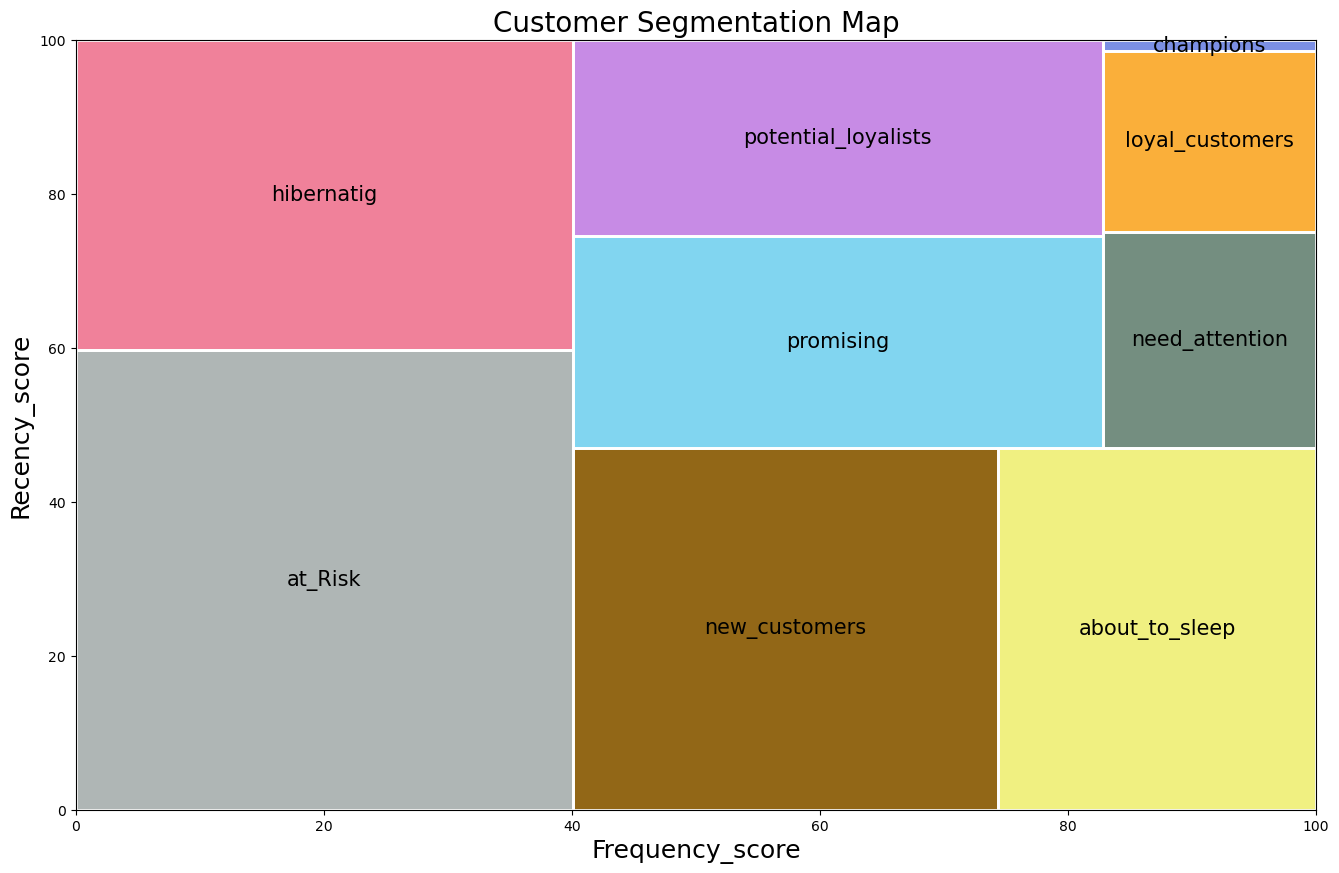

In [259]:
import squarify
import matplotlib.pyplot as plt

segments = df_rfmv2["segment"].value_counts().sort_values(ascending=False)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 10)
squarify.plot(
    sizes=segments,
    label=segments.index,  # Use segments.index as the labels
    color=[
        "#AFB6B5",
        "#F0819A",
        "#926717",
        "#F0F081",
        "#81D5F0",
        "#C78BE5",
        "#748E80",
        "#FAAF3A",
        "#7B8FE4",
        "#86E8C0",
    ],
    pad=False,
    bar_kwargs={"alpha": 1},
    text_kwargs={"fontsize": 15},
)

# Add white lines between the boxes
for shape in ax.patches:
    ax.add_patch(plt.Rectangle((shape.get_x(), shape.get_y()), shape.get_width(), shape.get_height(), fill=False, edgecolor='white', linewidth=2))

plt.title("Customer Segmentation Map", fontsize=20)
plt.xlabel("Frequency_score", fontsize=18)
plt.ylabel("Recency_score", fontsize=18)
plt.show()


In [261]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)


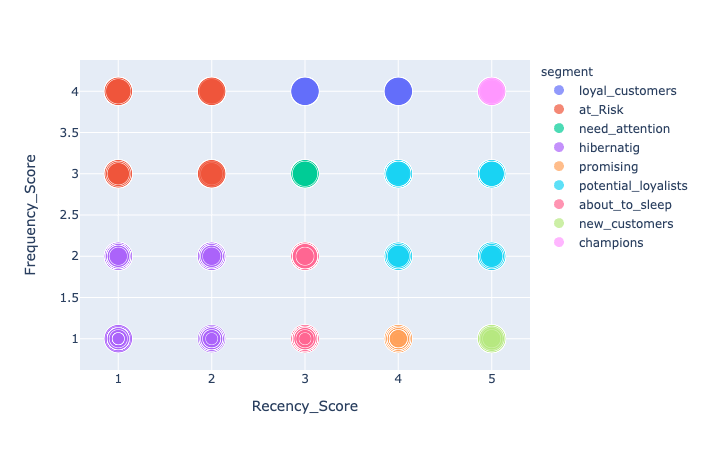

In [263]:
import plotly.express as px

fig = px.scatter(df_rfmv2, x="Recency_Score", y="Frequency_Score", color="segment", size='Monetary_Score', hover_data=['Monetary_Score'])

fig.show()


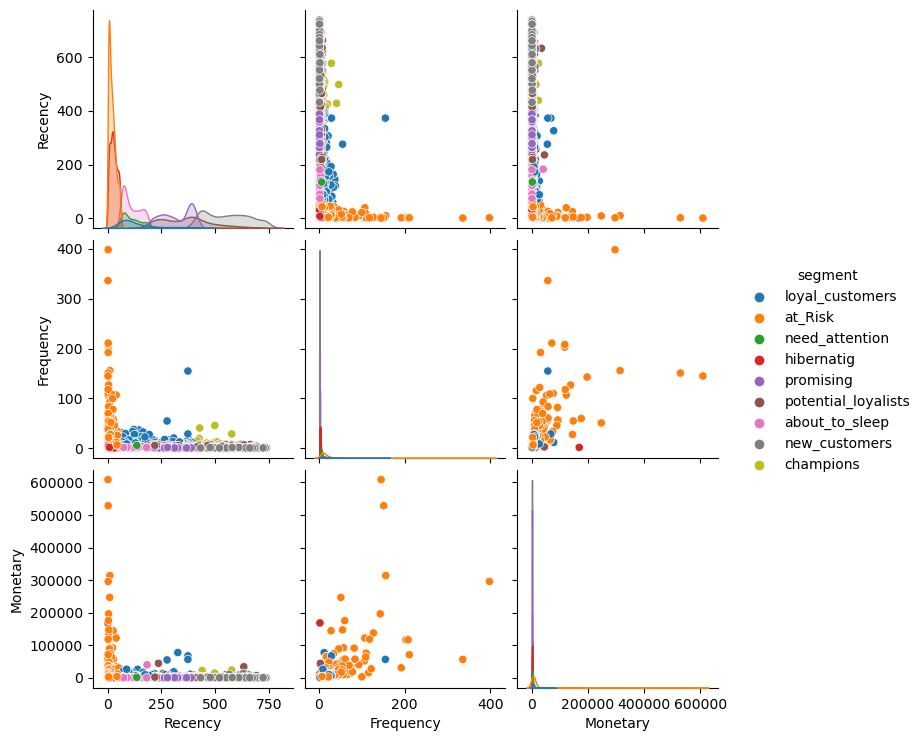

In [264]:
# Visualization of correlation results with seaborn library pairplot
sns.pairplot(df_rfm, hue = "segment")

# CLTV <a id = "4"></a>
고객 생애 가치(CLTV)는 고객과의 관계에서 생기는 미래 순이익을 예측한 수치입니다. 일정 기간 동안의 매출, 비용, 고객 행동 패턴을 고려하여 비즈니스가 고객 관계에서 얻을 수 있는 총 가치를 추정합니다. CLTV는 기업이 고객 확보 및 유지의 가치를 이해하고 고객 관계 관리 이니셔티브에 대한 투자에 대한 결정을 내리는 데 도움이 됩니다.

이 장에서는 데이터 집합에 몇 가지 변경 사항을 적용하겠습니다. 그런 다음 df_cltv를 생성한 다음 두 가지 모델을 적용하겠습니다. BetaGeoFitter and GammaGammaFitter models입니다. 베타지오필터 모델을 사용하여 고객의 쇼핑 빈도를 예측하겠습니다. GammaGammaFitter 모델을 사용하여 고객이 얼마나 많은 수익을 가져올지 예측할 것입니다. 그런 다음 데이터를 분석하겠습니다.

In [268]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total_Price
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.950,13085.000,United Kingdom,83.400
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750,13085.000,United Kingdom,81.000
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750,13085.000,United Kingdom,81.000
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.100,13085.000,United Kingdom,100.800
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.250,13085.000,United Kingdom,30.000


## 데이터에서 이상값 처리 <a id = "4a"></a>
In this chapter, I am going to calculate and subtract outlier values from the data

At the code blocks below, I am going to calculate the outlier with outlier_thresholds and then subtract it with replace_with_threshold.

In [269]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return up_limit, low_limit

def replace_with_threshold(dataframe, variable):
    up_limit, low_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

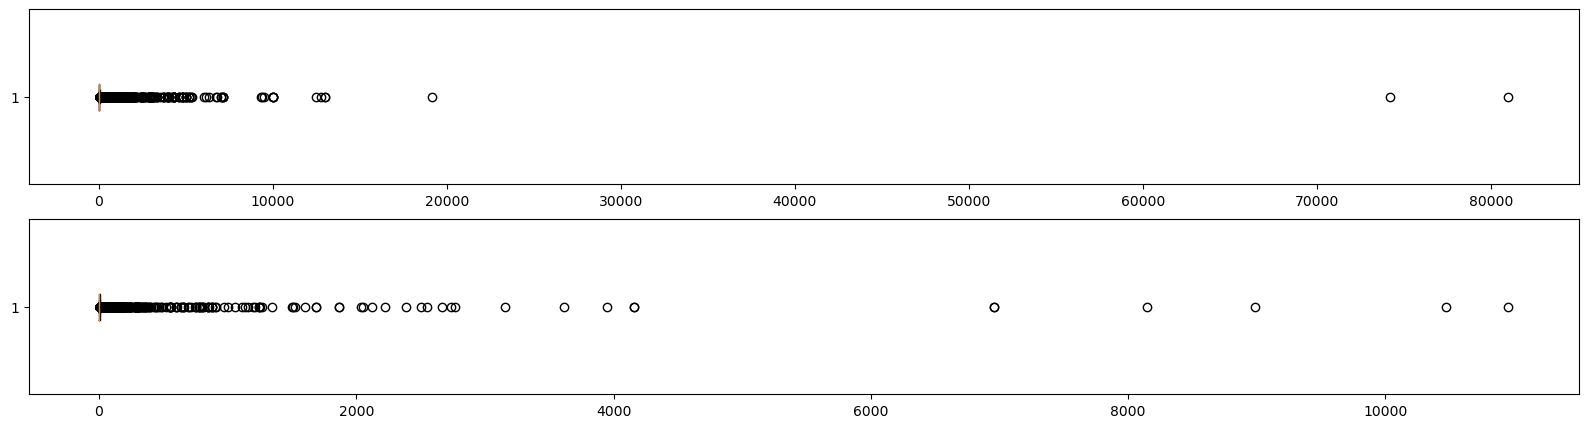

In [270]:
# I observe them before removing outliers.
f, ax = plt.subplots(2,1, figsize = (20,5))
col_list = ["Quantity", "Price"]
for i in range(0,2):
    ax[i].boxplot(data[col_list[i]], vert = 0)
plt.show()

In [273]:
# I apply the functions for remove the outlier.
replace_with_threshold(data, "Quantity")
replace_with_threshold(data, "Price")

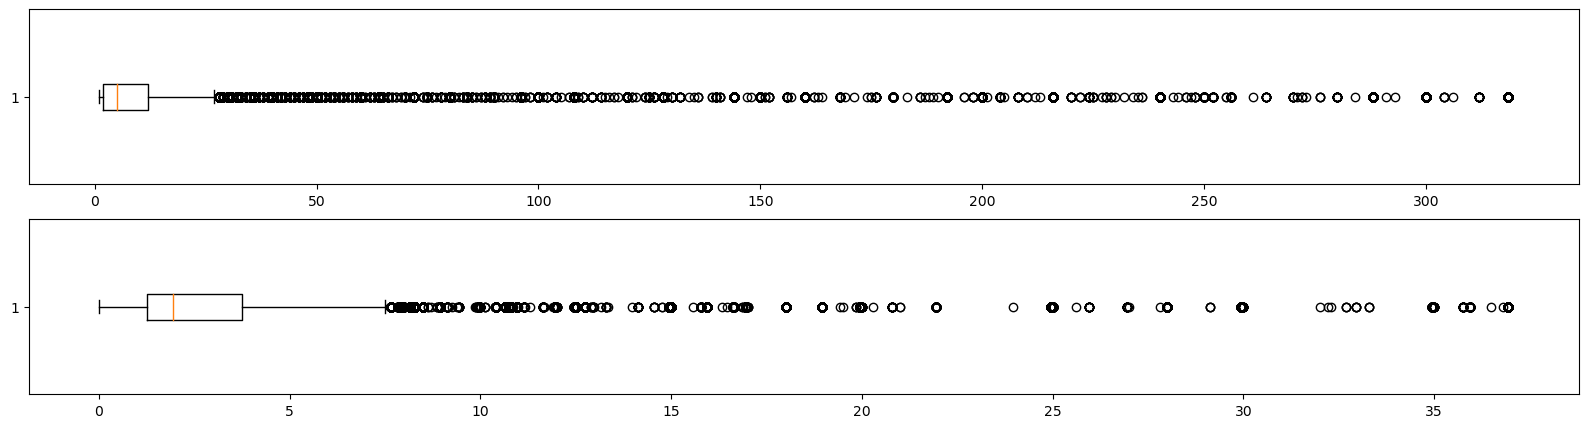

In [274]:
# I observe them after removing outliers.
f, ax = plt.subplots(2,1, figsize = (20,5))
for i in range(0,2):
    ax[i].boxplot(data[col_list[i]], vert = 0)
plt.show()

In [275]:
Df_info(data)

########### Head ###########
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS    12.000   
1  489434    79323P                   PINK CHERRY LIGHTS    12.000   
2  489434    79323W                  WHITE CHERRY LIGHTS    12.000   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE     48.000   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX    24.000   

          InvoiceDate  Price  Customer ID         Country  Total_Price  
0 2009-12-01 07:45:00  6.950    13085.000  United Kingdom       83.400  
1 2009-12-01 07:45:00  6.750    13085.000  United Kingdom       81.000  
2 2009-12-01 07:45:00  6.750    13085.000  United Kingdom       81.000  
3 2009-12-01 07:45:00  2.100    13085.000  United Kingdom      100.800  
4 2009-12-01 07:45:00  1.250    13085.000  United Kingdom       30.000  
########### Tail ###########
        Invoice StockCode                      Description  Quantity  \
1067366  58

## CLTV DataFrame 준비하기 <a id="4b"></a>
In this chapter, I am going to prepare the df_cltv dataframe from the first dataset.

In [276]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total_Price
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.000,2009-12-01 07:45:00,6.950,13085.000,United Kingdom,83.400
1,489434,79323P,PINK CHERRY LIGHTS,12.000,2009-12-01 07:45:00,6.750,13085.000,United Kingdom,81.000
2,489434,79323W,WHITE CHERRY LIGHTS,12.000,2009-12-01 07:45:00,6.750,13085.000,United Kingdom,81.000
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.000,2009-12-01 07:45:00,2.100,13085.000,United Kingdom,100.800
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.000,2009-12-01 07:45:00,1.250,13085.000,United Kingdom,30.000


In [277]:
# It is the last date in the dataset. I will need this to calculate the recency values. I'm going to use this to specify the today_date value.
data["InvoiceDate"].max()

Timestamp('2011-12-09 12:50:00')

In [281]:
today_date = dt.datetime(2011, 12, 11)

# Create the df_cltv dataframe.
df_cltv = data.groupby("Customer ID").agg({"InvoiceDate" : [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days, # recency
                                                  lambda InvoiceDate: (today_date - InvoiceDate.min()).days], # T
                                         "Invoice" : lambda Invoice: Invoice.nunique(), # frequnecy
                                         "Total_Price": lambda Total_Price: Total_Price.sum()}) # monatery

In [282]:
# First version of the df_cltv dataframe.
df_cltv.head()

InvoiceDate             Invoice Total_Price
             <lambda_0> <lambda_1> <lambda>    <lambda>
Customer ID                                            
12346.000           400        726       12   77556.460
12347.000           402        405        8    5633.320
12348.000           362        439        5    2019.400
12349.000           570        590        4    4428.690
12350.000             0        311        1     334.400

In [288]:
# I specify the column name of df_cltv
df_cltv.columns = ["recency", "T", "frequnecy", "monetary"]

In [290]:
df_cltv.head()

,recency,T,frequnecy,monetary
Customer ID,,,,
12346.000,400,726,12,77556.460
12347.000,402,405,8,5633.320
12348.000,362,439,5,2019.400
12349.000,570,590,4,4428.690
12350.000,0,311,1,334.400


In [292]:
df_cltv = df_cltv[df_cltv["frequnecy"] > 1]

In [293]:
df_cltv.head()

,recency,T,frequnecy,monetary
Customer ID,,,,
12346.000,400,726,12,77556.460
12347.000,402,405,8,5633.320
12348.000,362,439,5,2019.400
12349.000,570,590,4,4428.690
12352.000,356,393,10,2849.840


In [295]:
# turn the recency and T values to the weekly format 
df_cltv["recency"] = df_cltv["recency"] / 7
df_cltv["T"] = df_cltv["T"] / 7

In [296]:
df_cltv.head()

,recency,T,frequnecy,monetary
Customer ID,,,,
12346.000,57.143,103.714,12,77556.460
12347.000,57.429,57.857,8,5633.320
12348.000,51.714,62.714,5,2019.400
12349.000,81.429,84.286,4,4428.690
12352.000,50.857,56.143,10,2849.840


In [297]:
Df_info(df_cltv)

########### Head ###########
             recency       T  frequnecy  monetary
Customer ID                                      
12346.000     57.143 103.714         12 77556.460
12347.000     57.429  57.857          8  5633.320
12348.000     51.714  62.714          5  2019.400
12349.000     81.429  84.286          4  4428.690
12352.000     50.857  56.143         10  2849.840
########### Tail ###########
             recency       T  frequnecy  monetary
Customer ID                                      
18281.000     56.714  82.571          2   201.140
18282.000     16.857  18.143          2   178.050
18283.000     93.429  94.143         22  2736.650
18286.000     35.286 103.429          2  1296.430
18287.000     75.429  81.714          7  4182.990
########### Shape ###########
(4255, 4)
########### Info ###########
<class 'pandas.core.frame.DataFrame'>
Float64Index: 4255 entries, 12346.0 to 18287.0
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     

## BG-NBD <a id= "4c"></a>
In this section, I will apply the BetaGeoFitter model to the df_cltv I created.

In [298]:
# Model
bgf = BetaGeoFitter(penalizer_coef = 0.001)

# fit with frequency, recency, and T values.
bgf.fit(df_cltv["frequnecy"],
       df_cltv["recency"],
       df_cltv["T"])

<lifetimes.BetaGeoFitter: fitted with 4255 subjects, a: 0.24, alpha: 11.24, b: 3.06, r: 1.71>

In [303]:
# Calculating one monthly values
bgf.predict(4, 
           df_cltv["frequnecy"],
           df_cltv["recency"],
           df_cltv["T"]).sort_values(ascending = False).head(10)

Customer ID
14911.000   13.612
12748.000   11.542
17841.000    7.247
15311.000    7.143
13089.000    6.969
14606.000    6.610
14156.000    5.312
14646.000    5.201
18102.000    4.995
13694.000    4.934
dtype: float64

In [301]:
# Calculating three monthly values
bgf.predict(4*3, 
           df_cltv["frequnecy"],
           df_cltv["recency"],
           df_cltv["T"]).sort_values(ascending = False).head(10)

Customer ID
14911.000   40.522
12748.000   34.361
17841.000   21.573
15311.000   21.263
13089.000   20.746
14606.000   19.679
14156.000   15.814
14646.000   15.483
18102.000   14.869
13694.000   14.689
dtype: float64

In [305]:
# Adding the three monthly values to the df_cltv
df_cltv["expected_purc_3_month"] = bgf.predict(4*3, 
                                               df_cltv["frequnecy"],
                                               df_cltv["recency"],
                                               df_cltv["T"])

In [307]:
df_cltv.max()

recency                    105.429
T                          105.571
frequnecy                  398.000
monetary                608821.650
expected_purc_3_month       40.522
dtype: float64

In [308]:
# Calculating six monthly values
bgf.predict(4*6, 
           df_cltv["frequnecy"],
           df_cltv["recency"],
           df_cltv["T"]).sort_values(ascending = False).head(10)

Customer ID
14911.000   80.162
12748.000   67.971
17841.000   42.675
15311.000   42.064
13089.000   41.041
14606.000   38.929
14156.000   31.285
14646.000   30.630
18102.000   29.414
13694.000   29.059
dtype: float64

In [309]:
# Adding the six monthly values to the df_cltv
df_cltv["expected_purc_6_month"] = bgf.predict(4*6, 
                                               df_cltv["frequnecy"],
                                               df_cltv["recency"],
                                               df_cltv["T"])

In [310]:
df_cltv.head()

,recency,T,frequnecy,monetary,expected_purc_3_month,expected_purc_6_month
Customer ID,,,,,,
12346.000,57.143,103.714,12,77556.460,0.065,0.128
12347.000,57.429,57.857,8,5633.320,1.616,3.178
12348.000,51.714,62.714,5,2019.400,0.975,1.920
12349.000,81.429,84.286,4,4428.690,0.677,1.337
12352.000,50.857,56.143,10,2849.840,1.947,3.829


## Gamma Gamma <a id="4d"></a>
In this section, I will apply the GammaGammaFitter model to the df_cltv I created.

In [311]:
# Model
ggf = GammaGammaFitter(penalizer_coef = 0.01)

# fitting with frequency adn monetary values
ggf.fit(df_cltv["frequnecy"], df_cltv["monetary"])

<lifetimes.GammaGammaFitter: fitted with 4255 subjects, p: 3.19, q: 0.21, v: 3.13>

In [312]:
ggf.conditional_expected_average_profit(df_cltv["frequnecy"], df_cltv["monetary"]).sort_values(ascending = False).head(10)

Customer ID
18102.000   609867.515
14646.000   529474.442
14156.000   314447.604
14911.000   296157.667
17450.000   248183.196
13694.000   196825.082
16446.000   192394.040
17511.000   176334.379
16684.000   147811.084
12415.000   145752.851
dtype: float64

In [314]:
# Adding the prediction values to df_rfm.
df_cltv["expected_average_profit"] = ggf.conditional_expected_average_profit(df_cltv["frequnecy"], df_cltv["monetary"])

In [315]:
df_cltv.head()

,recency,T,frequnecy,monetary,expected_purc_3_month,expected_purc_6_month,expected_average_profit
Customer ID,,,,,,,
12346.000,57.143,103.714,12,77556.460,0.065,0.128,79197.806
12347.000,57.429,57.857,8,5633.320,1.616,3.178,5814.436
12348.000,51.714,62.714,5,2019.400,0.975,1.920,2125.742
12349.000,81.429,84.286,4,4428.690,0.677,1.337,4723.079
12352.000,50.857,56.143,10,2849.840,1.947,3.829,2922.831


- 돈을 많이 벌수록 

In [316]:
cltv = ggf.customer_lifetime_value(bgf,
                                  df_cltv["frequnecy"],
                                  df_cltv["recency"],
                                  df_cltv["T"],
                                  df_cltv["monetary"],
                                  time = 6, # six mounth
                                  freq = "W",
                                  discount_rate = 0.01)

In [317]:
cltv.head(10)

Customer ID
12346.000   10644.855
12347.000   19343.750
12348.000    4272.646
12349.000    6615.927
12352.000   11713.199
12353.000     419.527
12355.000     846.888
12356.000   16611.026
12357.000   32002.761
12358.000    5644.373
Name: clv, dtype: float64

In [318]:
# Adding the cltv values to the df_cltv.
df_cltv["cltv"] = cltv

In [319]:
df_cltv.head()

,recency,T,frequnecy,monetary,expected_purc_3_month,expected_purc_6_month,expected_average_profit,cltv
Customer ID,,,,,,,,
12346.000,57.143,103.714,12,77556.460,0.065,0.128,79197.806,10644.855
12347.000,57.429,57.857,8,5633.320,1.616,3.178,5814.436,19343.750
12348.000,51.714,62.714,5,2019.400,0.975,1.920,2125.742,4272.646
12349.000,81.429,84.286,4,4428.690,0.677,1.337,4723.079,6615.927
12352.000,50.857,56.143,10,2849.840,1.947,3.829,2922.831,11713.199


In [320]:
Df_info(df_cltv)

########### Head ###########
             recency       T  frequnecy  monetary  expected_purc_3_month  \
Customer ID                                                                
12346.000     57.143 103.714         12 77556.460                  0.065   
12347.000     57.429  57.857          8  5633.320                  1.616   
12348.000     51.714  62.714          5  2019.400                  0.975   
12349.000     81.429  84.286          4  4428.690                  0.677   
12352.000     50.857  56.143         10  2849.840                  1.947   

             expected_purc_6_month  expected_average_profit      cltv  
Customer ID                                                            
12346.000                    0.128                79197.806 10644.855  
12347.000                    3.178                 5814.436 19343.750  
12348.000                    1.920                 2125.742  4272.646  
12349.000                    1.337                 4723.079  6615.927  
12352.

## 세분화 <a id = "4e"></a>
In this chapter, I split the cltv values into segments.

In [322]:
df_cltv["segment"] = pd.qcut(df_cltv["cltv"], 4, labels = ["D", "C", "B", "A"])

In [323]:
df_cltv.head()

,recency,T,frequnecy,monetary,expected_purc_3_month,expected_purc_6_month,expected_average_profit,cltv,segment
Customer ID,,,,,,,,,
12346.000,57.143,103.714,12,77556.460,0.065,0.128,79197.806,10644.855,A
12347.000,57.429,57.857,8,5633.320,1.616,3.178,5814.436,19343.750,A
12348.000,51.714,62.714,5,2019.400,0.975,1.920,2125.742,4272.646,B
12349.000,81.429,84.286,4,4428.690,0.677,1.337,4723.079,6615.927,B
12352.000,50.857,56.143,10,2849.840,1.947,3.829,2922.831,11713.199,A


## Review The CLTV DataFrame <a id="4f"></a>
In this chapter, I am going to review the df_cltv.

In [324]:
df_cltv.head()

,recency,T,frequnecy,monetary,expected_purc_3_month,expected_purc_6_month,expected_average_profit,cltv,segment
Customer ID,,,,,,,,,
12346.000,57.143,103.714,12,77556.460,0.065,0.128,79197.806,10644.855,A
12347.000,57.429,57.857,8,5633.320,1.616,3.178,5814.436,19343.750,A
12348.000,51.714,62.714,5,2019.400,0.975,1.920,2125.742,4272.646,B
12349.000,81.429,84.286,4,4428.690,0.677,1.337,4723.079,6615.927,B
12352.000,50.857,56.143,10,2849.840,1.947,3.829,2922.831,11713.199,A


In [325]:
df_cltv.groupby("segment").agg({"count","mean","sum"})

recency                      T              frequnecy               \
              sum count   mean       sum count   mean       sum count   mean   
segment                                                                        
D       27916.143  1064 26.237 84623.571  1064 79.533      3780  1064  3.553   
C       55160.714  1064 51.843 72247.857  1064 67.902      3895  1064  3.661   
B       61967.143  1063 58.295 71070.714  1063 66.859      6479  1063  6.095   
A       84216.857  1064 79.151 88664.571  1064 83.331     21192  1064 19.917   

            monetary                 expected_purc_3_month              \
                 sum count      mean                   sum count  mean   
segment                                                                  
D        1214775.561  1064  1141.706               191.542  1064 0.180   
C        1054603.833  1064   991.169               788.103  1064 0.741   
B        2196687.136  1063  2066.498              1319.417  1063 1.241   
A       12709188.816  1064 11944.726              2788.486  1064 2.621   

        expected_purc_6_month             expected_average_profit        \
                          sum count  mean                     sum count   
segment                                                                   
D                     376.862  1064 0.354             1299230.568  1064   
C                    1543.954  1064 1.451             1141500.994  1064   
B                    2579.960  1063 2.427             2306504.886  1063   
A                    5492.209  1064 5.162            12892361.962  1064   

                           cltv                   
             mean           sum count       mean  
segment                                           
D        1221.081    202825.395  1064    190.625  
C        1072.839   1407161.355  1064   1322.520  
B        2169.807   5028342.287  1063   4730.331  
A       12116.882 175434009.770  1064 164881.588

In [326]:
df_cltv.sort_values(by = "recency", ascending = False).head()

,recency,T,frequnecy,monetary,expected_purc_3_month,expected_purc_6_month,expected_average_profit,cltv,segment
Customer ID,,,,,,,,,
15311.000,105.429,105.571,208,116771.160,21.263,42.064,116910.938,5151612.661,A
18102.000,105.429,105.571,145,608821.650,14.869,29.414,609867.515,18792065.099,A
14911.000,105.286,105.571,398,295972.630,40.522,80.162,296157.667,24869704.713,A
13599.000,105.286,105.571,33,10167.630,3.500,6.924,10244.921,74309.436,A
13777.000,105.286,105.429,61,56478.420,6.350,12.563,56709.639,746333.470,A


In [327]:
def check_cltv_best_and_worst(column):
    print(f"############ Top five - {column} ############")
    print(df_cltv.sort_values(by = column, ascending = False).head())
    print(f"############ Bottom five - {column} ############")
    print(df_cltv.sort_values(by = column, ascending = True).head())

In [328]:
check_cltv_best_and_worst("recency")

############ Top five - recency ############
             recency       T  frequnecy   monetary  expected_purc_3_month  \
Customer ID                                                                 
15311.000    105.429 105.571        208 116771.160                 21.263   
18102.000    105.429 105.571        145 608821.650                 14.869   
14911.000    105.286 105.571        398 295972.630                 40.522   
13599.000    105.286 105.571         33  10167.630                  3.500   
13777.000    105.286 105.429         61  56478.420                  6.350   

             expected_purc_6_month  expected_average_profit         cltv  \
Customer ID                                                                
15311.000                   42.064               116910.938  5151612.661   
18102.000                   29.414               609867.515 18792065.099   
14911.000                   80.162               296157.667 24869704.713   
13599.000                    6.924 

In [329]:
check_cltv_best_and_worst("frequnecy")

############ Top five - frequnecy ############
             recency       T  frequnecy   monetary  expected_purc_3_month  \
Customer ID                                                                 
14911.000    105.286 105.571        398 295972.630                 40.522   
12748.000    104.857 105.143        336  56599.390                 34.361   
17841.000    105.000 105.429        211  70884.070                 21.573   
15311.000    105.429 105.571        208 116771.160                 21.263   
13089.000    104.857 105.429        203 116737.860                 20.746   

             expected_purc_6_month  expected_average_profit         cltv  \
Customer ID                                                                
14911.000                   80.162               296157.667 24869704.713   
12748.000                   67.971                56641.317  4033014.081   
17841.000                   42.675                70967.718  3172600.226   
15311.000                   42.06

In [330]:
check_cltv_best_and_worst("monetary")

############ Top five - monetary ############
             recency       T  frequnecy   monetary  expected_purc_3_month  \
Customer ID                                                                 
18102.000    105.429 105.571        145 608821.650                 14.869   
14646.000    105.000 105.429        151 528602.520                 15.483   
14156.000    104.000 105.571        156 313946.370                 15.814   
14911.000    105.286 105.571        398 295972.630                 40.522   
17450.000     61.286  62.714         51 246973.090                  8.298   

             expected_purc_6_month  expected_average_profit         cltv  \
Customer ID                                                                
18102.000                   29.414               609867.515 18792065.099   
14646.000                   30.630               529474.442 16989056.187   
14156.000                   31.285               314447.604 10305198.849   
14911.000                   80.162

In [331]:
df_cltv.head()

,recency,T,frequnecy,monetary,expected_purc_3_month,expected_purc_6_month,expected_average_profit,cltv,segment
Customer ID,,,,,,,,,
12346.000,57.143,103.714,12,77556.460,0.065,0.128,79197.806,10644.855,A
12347.000,57.429,57.857,8,5633.320,1.616,3.178,5814.436,19343.750,A
12348.000,51.714,62.714,5,2019.400,0.975,1.920,2125.742,4272.646,B
12349.000,81.429,84.286,4,4428.690,0.677,1.337,4723.079,6615.927,B
12352.000,50.857,56.143,10,2849.840,1.947,3.829,2922.831,11713.199,A


In [332]:
# Correlation between the columns.
df_cltv.corr()

,recency,T,frequnecy,monetary,expected_purc_3_month,expected_purc_6_month,expected_average_profit,cltv
recency,1.000,0.706,0.379,0.186,0.245,0.252,0.185,0.092
T,0.706,1.000,0.251,0.121,-0.089,-0.080,0.120,0.058
frequnecy,0.379,0.251,1.000,0.625,0.879,0.883,0.622,0.648
monetary,0.186,0.121,0.625,1.000,0.562,0.565,1.000,0.858
expected_purc_3_month,0.245,-0.089,0.879,0.562,1.000,1.000,0.559,0.599
expected_purc_6_month,0.252,-0.080,0.883,0.565,1.000,1.000,0.562,0.602
expected_average_profit,0.185,0.120,0.622,1.000,0.559,0.562,1.000,0.855
cltv,0.092,0.058,0.648,0.858,0.599,0.602,0.855,1.000


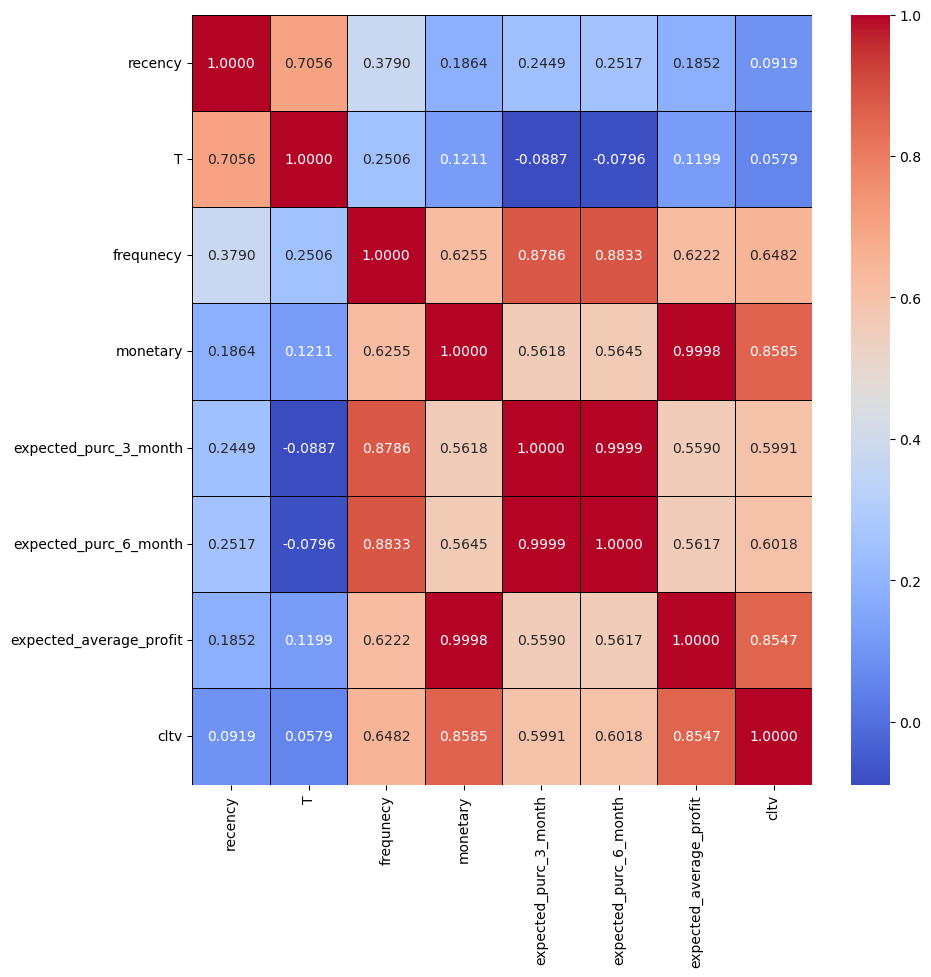

In [336]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_cltv.corr(), annot=True, linewidths=0.5, linecolor='black', cmap='coolwarm', fmt=".4f", ax=ax)
plt.show()


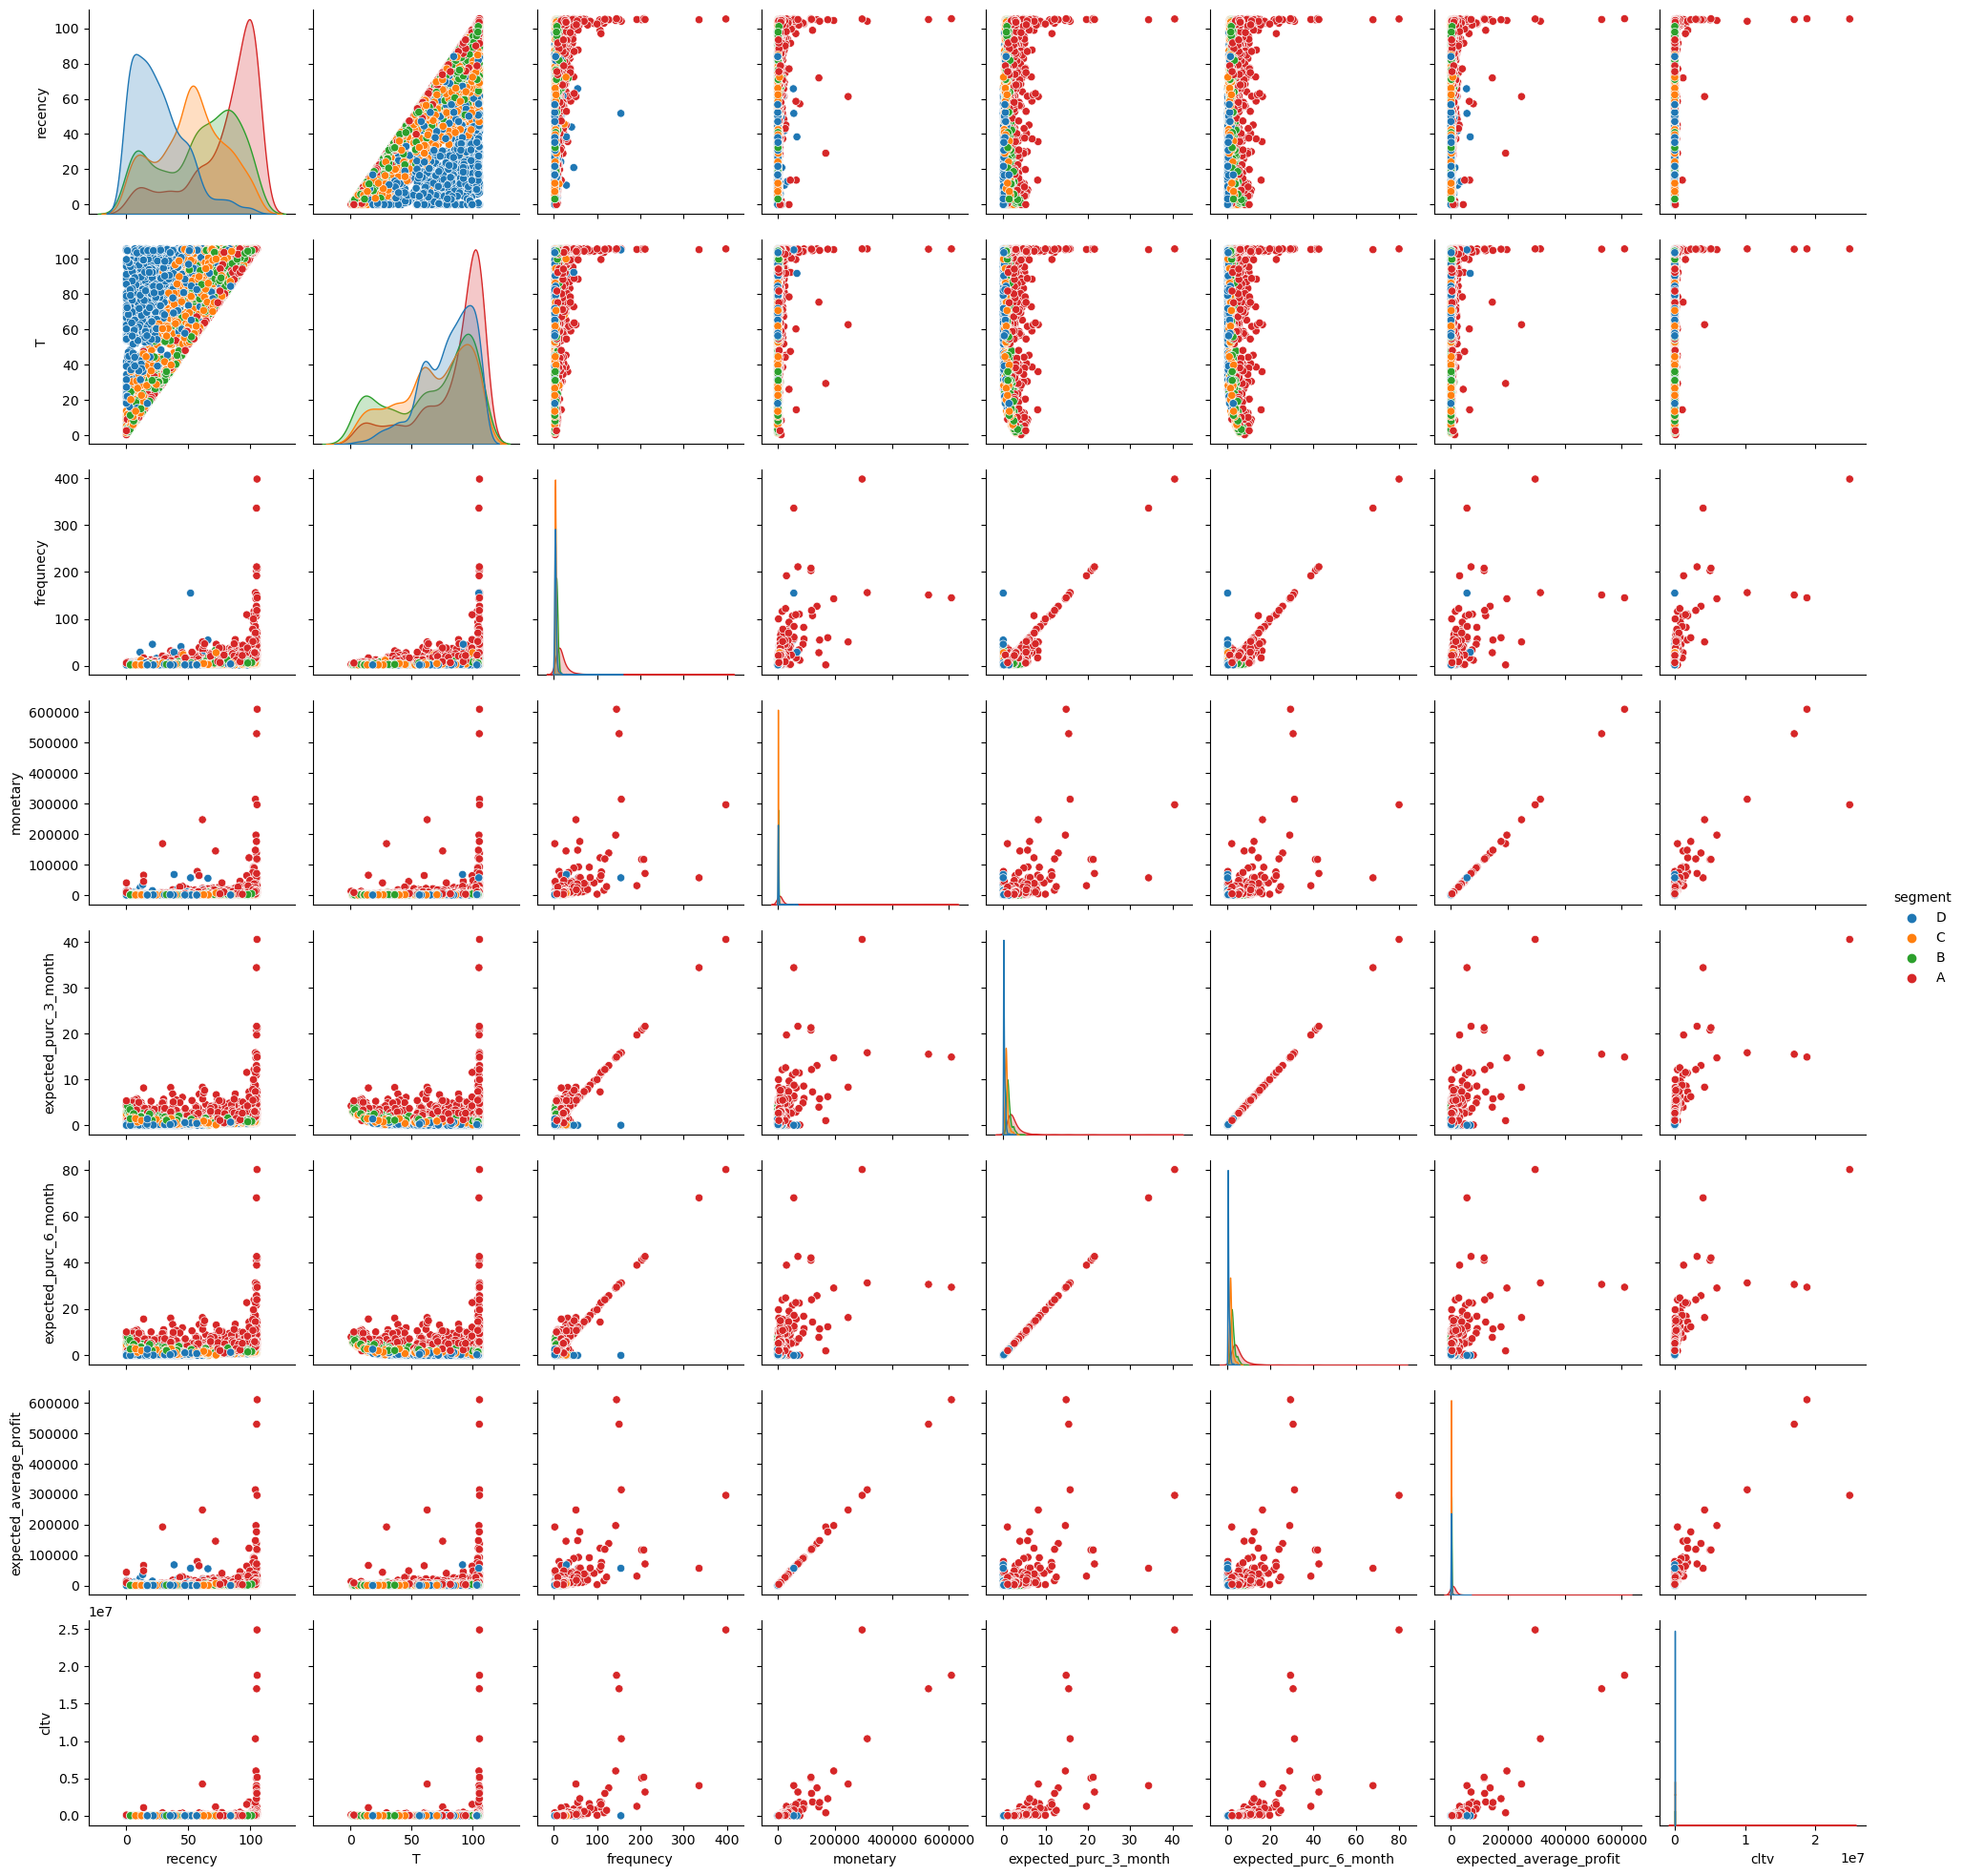

In [337]:
# Visualization of correlation results with seaborn library pairplot
sns.pairplot(df_cltv, hue = "segment")

In [ ]:
읽어주셔서 감사합니다.